In [1]:
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
from scipy import ndimage as ndi
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [49]:
ds1 = xr.open_dataset("/gws/nopw/j04/aopp/wkjones/seviri_labels/detected_dccs_SEVIRI_S20160714_000000_E20160715_000000_X0000_2081_Y0000_1601_fixed_linked_processed.nc")
anvil1 = 13494
ndi.find_objects(ds1.thick_anvil_label==anvil1)

[(slice(48, 69, None), slice(1288, 1315, None), slice(255, 295, None))]

In [76]:
ds1

<xarray.Dataset>
Dimensions:                             (along_track: 1601, across_track: 2081,
                                         t: 96, y: 1601, x: 2081, core: 1798,
                                         anvil: 1261, core_step: 8530,
                                         thick_anvil_step: 9418,
                                         thin_anvil_step: 10109)
Coordinates:
  * t                                   (t) datetime64[ns] 2016-07-14 ... 201...
  * along_track                         (along_track) int64 0 1 2 ... 1599 1600
  * across_track                        (across_track) int64 0 1 2 ... 2079 2080
  * core                                (core) int32 17641 17648 ... 19478 19479
  * anvil                               (anvil) int32 12219 12364 ... 14337
  * core_step                           (core_step) int32 88679 88680 ... 97208
  * thick_anvil_step                    (thick_anvil_step) int32 106696 ... 1...
  * thin_anvil_step                     (thin_anvil_step) int32 116206 ... 12...
Dimensions without coordinates: y, x
Data variables: (12/231)
    lat                                 (along_track, across_track) float32 ...
    lon                                 (along_track, across_track) float32 ...
    area                                (along_track, across_track) float32 ...
    core_label                          (t, y, x) int32 ...
    thick_anvil_label                   (t, y, x) int32 0 0 0 0 0 ... 0 0 0 0 0
    thin_anvil_label                    (t, y, x) int32 ...
    ...                                  ...
    thick_anvil_step_toa_cre_max        (thick_anvil_step) float32 ...
    thick_anvil_step_toa_cre_min        (thick_anvil_step) float32 ...
    thin_anvil_step_toa_cre_mean        (thin_anvil_step) float32 ...
    thin_anvil_step_toa_cre_std         (thin_anvil_step) float32 ...
    thin_anvil_step_toa_cre_max         (thin_anvil_step) float32 ...
    thin_anvil_step_toa_cre_min         (thin_anvil_step) float32 ...

In [51]:
ds1.t[slice(48, 69, None)]

<xarray.DataArray 't' (t: 21)>
array(['2016-07-14T12:00:00.000000000', '2016-07-14T12:15:00.000000000',
       '2016-07-14T12:30:00.000000000', '2016-07-14T12:45:00.000000000',
       '2016-07-14T13:00:00.000000000', '2016-07-14T13:15:00.000000000',
       '2016-07-14T13:30:00.000000000', '2016-07-14T13:45:00.000000000',
       '2016-07-14T14:00:00.000000000', '2016-07-14T14:15:00.000000000',
       '2016-07-14T14:30:00.000000000', '2016-07-14T14:45:00.000000000',
       '2016-07-14T15:00:00.000000000', '2016-07-14T15:15:00.000000000',
       '2016-07-14T15:30:00.000000000', '2016-07-14T15:45:00.000000000',
       '2016-07-14T16:00:00.000000000', '2016-07-14T16:15:00.000000000',
       '2016-07-14T16:30:00.000000000', '2016-07-14T16:45:00.000000000',
       '2016-07-14T17:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * t        (t) datetime64[ns] 2016-07-14T12:00:00 ... 2016-07-14T17:00:00

In [55]:
# Get flux data
from tobac_flow.dataloader import find_seviri_files
from tobac_flow.dataset import get_datetime_from_coord

start_date = get_datetime_from_coord(ds1.t[slice(48, 69, None)])[0]
end_date = get_datetime_from_coord(ds1.t[slice(48, 69, None)])[-1] + timedelta(hours=1)

flx_files = find_seviri_files(start_date, end_date, n_pad_files=0, file_type="flux", 
                              file_path="/gws/nopw/j04/eo_shared_data_vol1/satellite/seviri-orac/flx")

flx_ds = xr.open_mfdataset(flx_files, combine="nested", concat_dim="t")

flx_ds = flx_ds.assign_coords(t=[parse_date(f[-46:-34]) for f in flx_files])

/home/users/wkjones/miniconda3/envs/tobac_flow/lib/python3.10/site-packages/xarray/coding/times.py:209: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)


In [56]:
flx_ds

<xarray.Dataset>
Dimensions:       (t: 24, along_track: 1601, across_track: 2081)
Coordinates:
  * t             (t) datetime64[ns] 2016-07-14T12:00:00 ... 2016-07-14T17:45:00
Dimensions without coordinates: along_track, across_track
Data variables: (12/27)
    time          (t, along_track, across_track) datetime64[ns] dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    lat           (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    lon           (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    retrflag      (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    toa_swdn      (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    toa_swup      (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    ...            ...
    boa_psfc      (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    boa_qsfc      (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    lts           (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    fth           (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    colO3         (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
    cbh           (t, along_track, across_track) float32 dask.array<chunksize=(1, 1601, 2081), meta=np.ndarray>
Attributes: (12/36)
    Conventions:            CF-1.6,ACDD-1.3
    title:                  ESA Cloud CCI Retrieval Products L2 Primary File
    institution:            Deutscher Wetterdienst
    source:                 null
    history:                Dataset produced by DWDs CC4CL retrieval system i...
    references:             https://climate.esa.int/en/projects/cloud/
    ...                     ...
    Emissivity_File:        /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    USGS_File:              /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    Snow_File:              /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    Sea_Ice_File:           /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    Level1b_File:           /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...
    Geo_File:               /scratch/ms/de/sf7/esa_cci_c_proc/CCFLOW_SEV_DEV/...

In [57]:
slices1 = (slice(48, 69, None), slice(1250, 1350, None), slice(225, 325, None))
anim_anvil = ds1.thick_anvil_label[slices1]==anvil1
anim_core = np.isin(ds1.core_label[slices1], ds1.core[ds1.core_anvil_index==anvil1])
anim_flx = (flx_ds.toa_lwup_clr + flx_ds.toa_swup_clr - (flx_ds.toa_lwup + flx_ds.toa_swup)).sel(t=anim_anvil.t).isel(along_track=slices1[1], across_track=slices1[2])

/tmp/ipykernel_19801/817878091.py:43: UserWarning: No contour levels were found within the data range.
  cntr[1] = plt.contour(anim_core[i], [0.5], colors=['C3'])


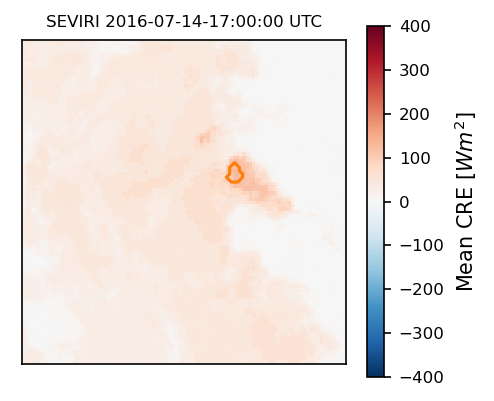

In [59]:
frames = 69 - 48

from matplotlib import animation
from dateutil.parser import parse as parse_date
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['animation.embed_limit'] = 2**128
# Animate brightness temperature and masks

fig = plt.figure(dpi=150, figsize=(3,3))
ax = plt.subplot(111)
i = 0

toa_img = anim_flx.data[i]
img = plt.imshow(toa_img, cmap="RdBu_r", vmin=-400, vmax=400)
cntr = []
cntr.extend([plt.contour(anim_anvil.data[i], [0.5], colors=['C1'])])
cntr.extend([plt.contour(anim_core[i], [0.5], colors=['C3'])])
plt.xticks([])
plt.yticks([])

title_date = parse_date(anim_anvil.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')
ax.set_title("SEVIRI "+title_date+" UTC", fontsize=8)

cbar = plt.colorbar(img, label="Mean CRE [$Wm^2$]")
cbar.ax.tick_params(labelsize=8)

plt.subplots_adjust(bottom=0.1, left=0.05, right=0.95)

def init():
    return img, cntr

def animate(i):
    toa_img = anim_flx.data[i]
    img.set_data(toa_img)
    for c in cntr:
        for coll in c.collections:
            try:
                coll.remove()
            except:
                pass
    cntr[0] = plt.contour(anim_anvil.data[i], [0.5], colors=['C1'])
    cntr[1] = plt.contour(anim_core[i], [0.5], colors=['C3'])
    title_date = parse_date(anim_anvil.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')
    ax.set_title("SEVIRI "+title_date+" UTC", fontsize=8)
    return img, cntr

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, 
                               interval=200, blit=False)

from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())

In [60]:
ds2 = xr.open_dataset("/gws/nopw/j04/aopp/wkjones/seviri_labels/detected_dccs_SEVIRI_S20160719_000000_E20160720_000000_X0000_2081_Y0000_1601_fixed_linked_processed.nc")
anvil2 = 18923
ndi.find_objects(ds2.thick_anvil_label==anvil2)

[(slice(10, 86, None), slice(10, 130, None), slice(103, 191, None))]

In [61]:
# Get flux data
from tobac_flow.dataloader import find_seviri_files
from tobac_flow.dataset import get_datetime_from_coord

start_date = get_datetime_from_coord(ds2.t[slice(10, 86, None)])[0]
end_date = get_datetime_from_coord(ds2.t[slice(10, 86, None)])[-1] + timedelta(hours=1)

flx_files = find_seviri_files(start_date, end_date, n_pad_files=0, file_type="flux", 
                              file_path="/gws/nopw/j04/eo_shared_data_vol1/satellite/seviri-orac/flx")

flx_ds2 = xr.open_mfdataset(flx_files, combine="nested", concat_dim="t")

flx_ds2 = flx_ds2.assign_coords(t=[parse_date(f[-46:-34]) for f in flx_files])

/home/users/wkjones/miniconda3/envs/tobac_flow/lib/python3.10/site-packages/xarray/coding/times.py:209: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)


In [63]:
slices2 = (slice(10, 86, None), slice(0, 150, None), slice(75, 225, None))
anim_anvil = ds2.thick_anvil_label[slices2]==anvil2
anim_core = np.isin(ds2.core_label[slices2], ds2.core[ds2.core_anvil_index==anvil2])
anim_flx = (flx_ds2.toa_lwup_clr + flx_ds2.toa_swup_clr - (flx_ds2.toa_lwup + flx_ds2.toa_swup)).sel(t=anim_anvil.t).isel(along_track=slices2[1], across_track=slices2[2])

/tmp/ipykernel_19801/1175829713.py:18: UserWarning: No contour levels were found within the data range.
  cntr.extend([plt.contour(anim_core[i], [0.5], colors=['C3'])])
/tmp/ipykernel_19801/1175829713.py:43: UserWarning: No contour levels were found within the data range.
  cntr[1] = plt.contour(anim_core[i], [0.5], colors=['C3'])


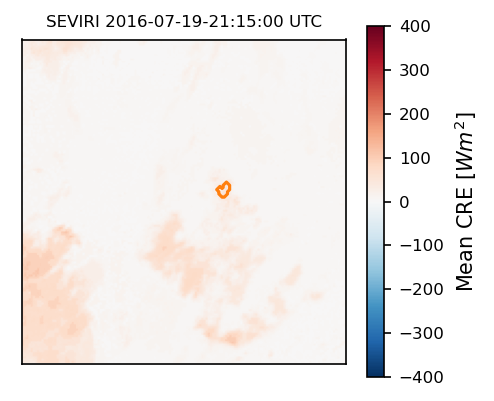

In [65]:
frames = 86 - 10

from matplotlib import animation
from dateutil.parser import parse as parse_date
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['animation.embed_limit'] = 2**128
# Animate brightness temperature and masks

fig = plt.figure(dpi=150, figsize=(3,3))
ax = plt.subplot(111)
i = 0

toa_img = anim_flx.data[i]
img = plt.imshow(toa_img, cmap="RdBu_r", vmin=-400, vmax=400)
cntr = []
cntr.extend([plt.contour(anim_anvil.data[i], [0.5], colors=['C1'])])
cntr.extend([plt.contour(anim_core[i], [0.5], colors=['C3'])])
plt.xticks([])
plt.yticks([])

title_date = parse_date(anim_anvil.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')
ax.set_title("SEVIRI "+title_date+" UTC", fontsize=8)

cbar = plt.colorbar(img, label="Mean CRE [$Wm^2$]")
cbar.ax.tick_params(labelsize=8)

plt.subplots_adjust(bottom=0.1, left=0.05, right=0.95)

def init():
    return img, cntr

def animate(i):
    toa_img = anim_flx.data[i]
    img.set_data(toa_img)
    for c in cntr:
        for coll in c.collections:
            try:
                coll.remove()
            except:
                pass
    cntr[0] = plt.contour(anim_anvil.data[i], [0.5], colors=['C1'])
    cntr[1] = plt.contour(anim_core[i], [0.5], colors=['C3'])
    title_date = parse_date(anim_anvil.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')
    ax.set_title("SEVIRI "+title_date+" UTC", fontsize=8)
    return img, cntr

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, 
                               interval=100, blit=False)

from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())

In [66]:
ds3 = xr.open_dataset("/gws/nopw/j04/aopp/wkjones/seviri_labels/detected_dccs_SEVIRI_S20160813_000000_E20160814_000000_X0000_2081_Y0000_1601_fixed_linked_processed.nc")
anvil3 = 9871
ndi.find_objects(ds3.thick_anvil_label==anvil3)

[(slice(23, 93, None), slice(1423, 1594, None), slice(651, 913, None))]

In [68]:
t_slice = slice(23, 93, None)

In [69]:
# Get flux data
from tobac_flow.dataloader import find_seviri_files
from tobac_flow.dataset import get_datetime_from_coord

start_date = get_datetime_from_coord(ds3.t[t_slice])[0]
end_date = get_datetime_from_coord(ds3.t[t_slice])[-1] + timedelta(hours=1)

flx_files = find_seviri_files(start_date, end_date, n_pad_files=0, file_type="flux", 
                              file_path="/gws/nopw/j04/eo_shared_data_vol1/satellite/seviri-orac/flx")

flx_ds3 = xr.open_mfdataset(flx_files, combine="nested", concat_dim="t")

flx_ds3 = flx_ds3.assign_coords(t=[parse_date(f[-46:-34]) for f in flx_files])

/home/users/wkjones/miniconda3/envs/tobac_flow/lib/python3.10/site-packages/xarray/coding/times.py:209: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)


In [73]:
slices3 = (t_slice, slice(1374, 1675, None), slice(625, 925, None))
anim_anvil = ds3.thick_anvil_label[slices3]==anvil3
anim_core = np.isin(ds3.core_label[slices3], ds3.core[ds3.core_anvil_index==anvil3])
anim_flx = (flx_ds3.toa_lwup_clr + flx_ds3.toa_swup_clr - (flx_ds3.toa_lwup + flx_ds3.toa_swup)).sel(t=anim_anvil.t).isel(along_track=slices3[1], across_track=slices3[2])

/tmp/ipykernel_19801/3141857482.py:18: UserWarning: No contour levels were found within the data range.
  cntr.extend([plt.contour(anim_core[i], [0.5], colors=['C3'])])
/tmp/ipykernel_19801/3141857482.py:43: UserWarning: No contour levels were found within the data range.
  cntr[1] = plt.contour(anim_core[i], [0.5], colors=['C3'])


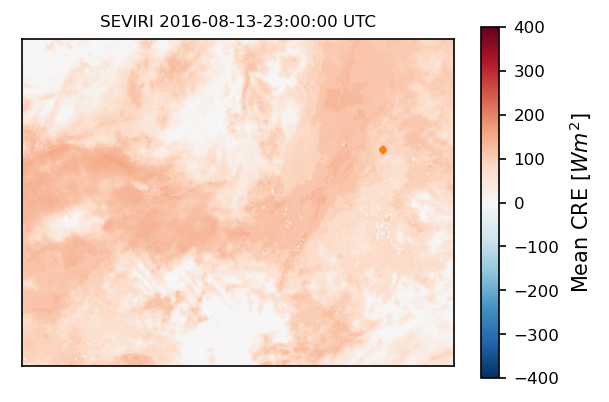

In [75]:
frames = t_slice.stop - t_slice.start

from matplotlib import animation
from dateutil.parser import parse as parse_date
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['animation.embed_limit'] = 2**128
# Animate brightness temperature and masks

fig = plt.figure(dpi=150, figsize=(4,3))
ax = plt.subplot(111)
i = 0

toa_img = anim_flx.data[i]
img = plt.imshow(toa_img, cmap="RdBu_r", vmin=-400, vmax=400)
cntr = []
cntr.extend([plt.contour(anim_anvil.data[i], [0.5], colors=['C1'])])
cntr.extend([plt.contour(anim_core[i], [0.5], colors=['C3'])])
plt.xticks([])
plt.yticks([])

title_date = parse_date(anim_anvil.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')
ax.set_title("SEVIRI "+title_date+" UTC", fontsize=8)

cbar = plt.colorbar(img, label="Mean CRE [$Wm^2$]")
cbar.ax.tick_params(labelsize=8)

plt.subplots_adjust(bottom=0.1, left=0.05, right=0.95)

def init():
    return img, cntr

def animate(i):
    toa_img = anim_flx.data[i]
    img.set_data(toa_img)
    for c in cntr:
        for coll in c.collections:
            try:
                coll.remove()
            except:
                pass
    cntr[0] = plt.contour(anim_anvil.data[i], [0.5], colors=['C1'])
    cntr[1] = plt.contour(anim_core[i], [0.5], colors=['C3'])
    title_date = parse_date(anim_anvil.t.astype('datetime64[s]').data[i].astype(str)).strftime('%Y-%m-%d-%H:%M:%S')
    ax.set_title("SEVIRI "+title_date+" UTC", fontsize=8)
    return img, cntr

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, 
                               interval=100, blit=False)

from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())